# Homework #9 (Due 11/12/2020, 11:59pm)
## Bayesian Neural Network Logistic Regression

**AM 207: Advanced Scientific Computing**<br>
**Instructor: Weiwei Pan**<br>
**Fall 2020**

**Name:**

**Students collaborators:**

### Instructions:

**Submission Format:** Use this notebook as a template to complete your homework. Please intersperse text blocks (using Markdown cells) amongst `python` code and results -- format your submission for maximum readability. Your assignments will be graded for correctness as well as clarity of exposition and presentation -- a “right” answer by itself without an explanation or is presented with a difficult to follow format will receive no credit.

**Code Check:** Before submitting, you must do a "Restart and Run All" under "Kernel" in the Jupyter or colab menu. Portions of your submission that contains syntactic or run-time errors will not be graded.

**Libraries and packages:** Unless a problems specifically asks you to implement from scratch, you are welcomed to use any `python` library package in the standard Anaconda distribution.

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import autograd.numpy as np
import autograd.numpy.random as npr
from autograd import grad
import itertools as it
from autograd.misc.optimizers import adam, sgd
from autograd import scipy as sp
import pandas as pd
import numpy
from sklearn.datasets import fetch_openml
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.preprocessing import PolynomialFeatures
from pymc3 import Model
import pymc3 as pm
import matplotlib.pyplot as plt
import sys
%matplotlib inline

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
def sigmoid(x):
    return 1/(1 + np.exp(-x))

In [6]:
def plot_decision_boundary(x, y, models, ax, poly_degree=1, test_points=None, shaded=True, annotate_train=None, annotate_test=None):
    '''
    plot_decision_boundary plots the training data and the decision boundary of the classifier.
    input:
       x - a numpy array of size N x 2, each row is a patient, each column is a biomarker
       y - a numpy array of length N, each entry is either 0 (no cancer) or 1 (cancerous)
       models - an array of classification models
       ax - axis to plot on
       poly_degree - the degree of polynomial features used to fit the model
       test_points - test data
       shaded - whether or not the two sides of the decision boundary are shaded
    returns: 
       ax - the axis with the scatter plot
    
    '''
    # Plot data
    ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.2, c='red', label='class 1')
    ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.2, c='blue', label='class 0')
    
    # Create mesh
    interval = np.arange(-6, 6, 0.1)
    n = np.size(interval)
    x1, x2 = np.meshgrid(interval, interval)
    x1 = x1.reshape(-1, 1)
    x2 = x2.reshape(-1, 1)
    xx = np.concatenate((x1, x2), axis=1)

    # Predict on mesh points
    if(poly_degree > 1):
        polynomial_features = PolynomialFeatures(degree=poly_degree, include_bias=False)
        xx = polynomial_features.fit_transform(xx)
    
    if len(models) > 1:
        alpha_line = 0.1
        linewidths=0.1
    else:
        alpha_line = 0.8
        linewidths=0.5
        
    i = 0
    
    if annotate_train is not None:
        train_variance_plot = [round(var, 3) for var in annotate_train]
        
    if annotate_test is not None:
        test_variance_plot = [round(var, 3) for var in annotate_test]
        
        
    for model in models:
        yy = model.predict(xx)
        yy = yy.reshape((n, n))
        
        # Plot decision surface
        x1 = x1.reshape(n, n)
        x2 = x2.reshape(n, n)
        if shaded:
            ax.contourf(x1, x2, yy, alpha=0.1 * 1. / (i + 1)**2, cmap='bwr')
        ax.contour(x1, x2, yy, colors='black', linewidths=linewidths, alpha=alpha_line)
        i += 1

    if test_points is not None:
        for i in range(len(test_points)):
            pt = test_points[i]
            if i == 0:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
            else:
                ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
            
            ax.annotate(test_variance_plot[i], (test_points[i][0], test_points[i][1]))
            
    for i, txt in enumerate(train_variance_plot):
        if float(txt) > 0.05: 
            ax.annotate(txt, (x[i][0], x[i][1]))

    ax.set_xlim((-5.5, 5.5))
    ax.set_ylim((-5.5, 5.5))
    ax.set_xlabel('x_1')
    ax.set_ylabel('x_2')
    ax.legend(loc='best')
    return ax


class Bayesian_logistic_regression:
    
    def __init__(self, weights, forward):
        self.weights = weights
        self.forward = forward
        
    def predict(self, x):
        p = self.forward(self.weights, x.T)
        return (p > 0.5).astype(np.int_)

    def predict_proba(self, x):
        return self.forward(self.weights, x.T)

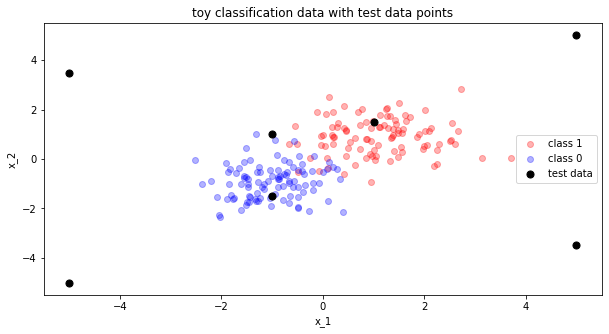

In [8]:
# Generate a toy dataset for classification
samples = 100
class_0 = np.random.multivariate_normal([-1, -1], 0.5 * np.eye(2), samples)
class_1 = np.random.multivariate_normal([1, 1], 0.5 * np.eye(2), samples)
x = np.vstack((class_0, class_1))
y = np.array([0] * 100 + [1] * 100)
# Define test data points
test_points = [(-5, -5), (-5, 3.5), (5, 5), (5, -3.5), (-1, 1), (-1, -1.5), (1, 1.5)]
# Visualize our test data points
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
ax.scatter(x[y == 1, 0], x[y == 1, 1], alpha=0.3, color='red', label='class 1')
ax.scatter(x[y == 0, 0], x[y == 0, 1], alpha=0.3, color='blue', label='class 0')
for i in range(len(test_points)):
    pt = test_points[i]
    if i == 0:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black', label='test data')
    else:
        ax.scatter(pt[0], pt[1], alpha=1., s=50, color='black')
ax.set_xlabel('x_1')
ax.set_ylabel('x_2')
ax.set_title('toy classification data with test data points')
ax.legend(loc='best')
plt.show()

##### Neural Network

Define a Neural Network Class and instantiate an object of this class. 

In [18]:
class Feedforward:
    
    def __init__(self, architecture, random=None, weights=None):
        self.params = {'H': architecture['width'],
                       'L': architecture['hidden_layers'],
                       'D_in': architecture['input_dim'],
                       'D_out': architecture['output_dim'],
                       'activation_type': architecture['activation_fn_type'],
                       'activation_params': architecture['activation_fn_params']}

        self.D = (  (architecture['input_dim'] * architecture['width'] + architecture['width'])
                  + (architecture['output_dim'] * architecture['width'] + architecture['output_dim'])
                  + (architecture['hidden_layers'] - 1) * (architecture['width']**2 + architecture['width'])
                 )  # in order: input, output, hidden. Take into account the biases

        if random is not None:
            self.random = random
        else:
            self.random = np.random.RandomState(0)

        self.h = architecture['activation_fn']

        if weights is None:
            self.weights = self.random.normal(0, 1, size=(1, self.D))
        else:
            self.weights = weights

        self.objective_trace = np.empty((1, 1))
        self.weight_trace = np.empty((1, self.D))


    def forward(self, weights, x):
        ''' Forward pass given weights and input '''
        H = self.params['H']
        D_in = self.params['D_in']
        D_out = self.params['D_out']
        assert weights.shape[1] == self.D

        if len(x.shape) == 2:
            assert x.shape[0] == D_in
            x = x.reshape((1, D_in, -1))
        else:
            assert x.shape[1] == D_in

        weights = weights.T


        #input to first hidden layer
        W = weights[:H * D_in].T.reshape((-1, H, D_in))
        b = weights[H * D_in:H * D_in + H].T.reshape((-1, H, 1))
        input = self.h(np.matmul(W, x) + b)
        index = H * D_in + H

        assert input.shape[1] == H

        #additional hidden layers
        for _ in range(self.params['L'] - 1):
            before = index
            W = weights[index:index + H * H].T.reshape((-1, H, H))
            index += H * H
            b = weights[index:index + H].T.reshape((-1, H, 1))
            index += H
            output = np.matmul(W, input) + b
            input = self.h(output)

            assert input.shape[1] == H

        #output layer
        W = weights[index:index + H * D_out].T.reshape((-1, D_out, H))
        b = weights[index + H * D_out:].T.reshape((-1, D_out, 1))
        
        output = sigmoid(np.matmul(W, input) + b) # review that for training
        assert output.shape[1] == self.params['D_out']

        return output

    def make_objective(self, x_train, y_train, reg_param):  

        def objective(W, t):
            sigmoid_probability = self.forward(W, x_train).flatten()
            sigmoid_probability = np.clip(sigmoid_probability, 1e-15, 1-1e-15)
            bce = np.dot(y_train, np.log(sigmoid_probability)) + np.dot((1-y_train), np.log(1 - sigmoid_probability))
            if reg_param is None:
                sum_error = bce
                return -sum_error
            else:
                mean_error = bce + reg_param * np.linalg.norm(W)
                return -mean_error

        return objective, grad(objective)

    def fit(self, x_train, y_train, params, reg_param=None):

        assert x_train.shape[0] == self.params['D_in']
        assert y_train.shape[0] == self.params['D_out']

        ### make objective function for training
        self.objective, self.gradient = self.make_objective(x_train, y_train, reg_param)

        ### set up optimization
        step_size = 0.01
        max_iteration = 5000
        check_point = 100
        weights_init = self.weights.reshape((1, -1))
        mass = None
        optimizer = 'adam'
        random_restarts = 5

        if 'step_size' in params.keys():
            step_size = params['step_size']
        if 'max_iteration' in params.keys():
            max_iteration = params['max_iteration']
        if 'check_point' in params.keys():
            self.check_point = params['check_point']
        if 'init' in params.keys():
            weights_init = params['init']
        if 'call_back' in params.keys():
            call_back = params['call_back']
        if 'mass' in params.keys():
            mass = params['mass']
        if 'optimizer' in params.keys():
            optimizer = params['optimizer']
        if 'random_restarts' in params.keys():
            random_restarts = params['random_restarts']

        def call_back(weights, iteration, g):
            ''' Actions per optimization step '''
            objective = self.objective(weights, iteration)
            self.objective_trace = np.vstack((self.objective_trace, objective))
            self.weight_trace = np.vstack((self.weight_trace, weights))
            if iteration % check_point == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(iteration, objective, np.linalg.norm(self.gradient(weights, iteration))))

        ### train with random restarts
        optimal_obj = 1e16
        optimal_weights = self.weights

        for i in range(random_restarts):
            if optimizer == 'adam':
                adam(self.gradient, weights_init, step_size=step_size, num_iters=max_iteration, callback=call_back)
            local_opt = np.min(self.objective_trace[-100:])
            if local_opt < optimal_obj:
                opt_index = np.argmin(self.objective_trace[-100:])
                self.weights = self.weight_trace[-100:][opt_index].reshape((1, -1))
            weights_init = self.random.normal(0, 1, size=(1, self.D))

        self.objective_trace = self.objective_trace[1:]
        self.weight_trace = self.weight_trace[1:]

In [19]:
###relu activation
activation_fn_type = 'relu'
activation_fn = lambda x: np.maximum(np.zeros(x.shape), x)


###neural network model design choices
width = 5
hidden_layers = 1
input_dim = 2
output_dim = 1

architecture = {'width': width,
               'hidden_layers': hidden_layers,
               'input_dim': input_dim,
               'output_dim': output_dim,
               'activation_fn_type': 'relu',
               'activation_fn_params': 'rate=1',
               'activation_fn': activation_fn}

#set random state to make the experiments replicable
rand_state = 0
random = np.random.RandomState(rand_state)

#instantiate a Feedforward neural network object
nn = Feedforward(architecture, random=random)

##### First, train the NN in a MLE fashion in order to get good initialization points for w

In [20]:
###define design choices in gradient descent
params = {'step_size':1e-3, 
          'max_iteration':20000, 
          'random_restarts':1}
#fit my neural network to minimize MSE on the given data
nn.fit(x.T, y.reshape(1, -1), params)

Iteration 0 lower bound [30.64810151]; gradient mag: 25.352959285745566
Iteration 100 lower bound [25.38129673]; gradient mag: 13.549732867358104
Iteration 200 lower bound [22.37915571]; gradient mag: 9.530643229252115
Iteration 300 lower bound [20.47710684]; gradient mag: 7.087973987606146
Iteration 400 lower bound [19.31350066]; gradient mag: 5.08820989037958
Iteration 500 lower bound [18.58412547]; gradient mag: 3.787853069405134
Iteration 600 lower bound [18.14145142]; gradient mag: 2.8395223165031207
Iteration 700 lower bound [17.82841276]; gradient mag: 2.2817696510546894
Iteration 800 lower bound [17.59838218]; gradient mag: 1.9446490831300138
Iteration 900 lower bound [17.41559402]; gradient mag: 1.5949757694793443
Iteration 1000 lower bound [17.26296213]; gradient mag: 1.4092838281206226
Iteration 1100 lower bound [17.12261021]; gradient mag: 1.2815902215632156
Iteration 1200 lower bound [17.04133054]; gradient mag: 1.0477928418452245
Iteration 1300 lower bound [16.97079678]; 

Iteration 11000 lower bound [14.45227198]; gradient mag: 2.055919120534505
Iteration 11100 lower bound [14.44337837]; gradient mag: 2.1052492343952474
Iteration 11200 lower bound [14.437034]; gradient mag: 2.3036851638122973
Iteration 11300 lower bound [14.42902934]; gradient mag: 2.580022100254344
Iteration 11400 lower bound [14.42275731]; gradient mag: 2.4092064773615673
Iteration 11500 lower bound [14.41509142]; gradient mag: 2.3868118262326843
Iteration 11600 lower bound [14.40881066]; gradient mag: 2.446632866334767
Iteration 11700 lower bound [14.40302582]; gradient mag: 2.941680064887358
Iteration 11800 lower bound [14.39683296]; gradient mag: 2.80666719040809
Iteration 11900 lower bound [14.39084084]; gradient mag: 2.560694644585718
Iteration 12000 lower bound [14.38490546]; gradient mag: 2.6575263069514907
Iteration 12100 lower bound [14.37953366]; gradient mag: 2.701040008548779
Iteration 12200 lower bound [14.37353256]; gradient mag: 2.41985531753334
Iteration 12300 lower bo

In [33]:
Blr = Bayesian_logistic_regression(nn.weights, nn.forward)
print('Mean accuracy', np.mean(Blr.predict(x).flatten()==y))

Mean accuracy 0.96


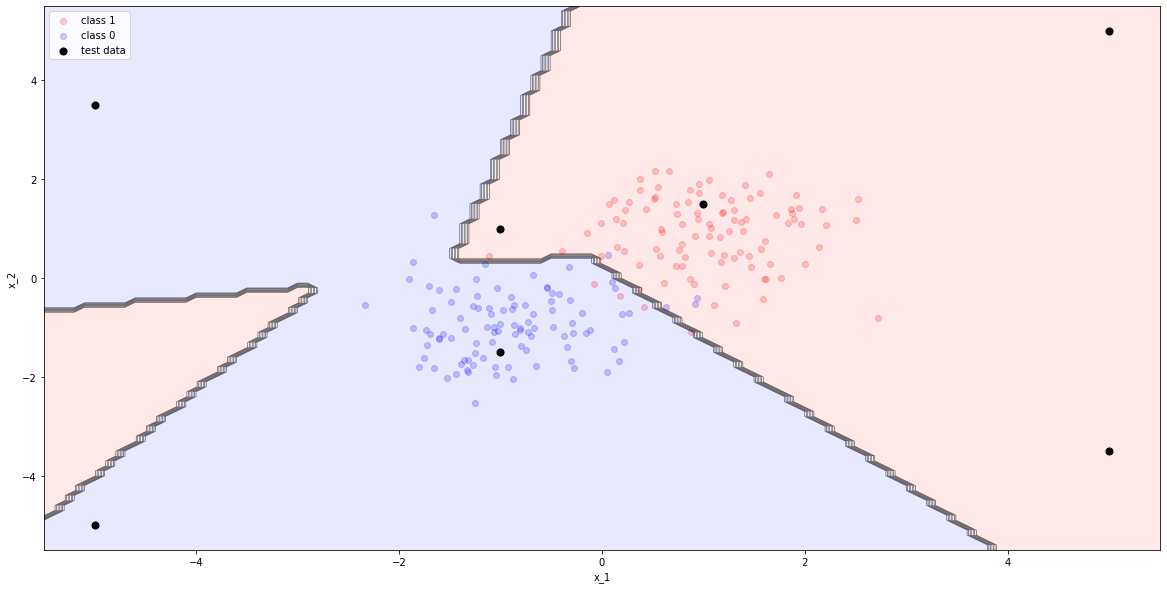

In [36]:
fig, ax=plt.subplots(1, figsize = (20, 10))
plot_decision_boundary(x, y, [Blr], ax, test_points=test_points)
plt.show(fig)

## Problem Description: Inference for Bayesian Neural Network Logistic Regression Models
In HW#7, we evaluated the usefulness of the predictive uncertainties Logistic Regression models and Bayesian Logistic Regression models for test data that are dissimilar to our training data. These test data points are called ***out of distribution (OOD) points***. Just as in Homework #2, we want the predictive uncertainties from our models to help us distinguish ***in-distribution*** test data (test data that are similar to data on which we trained our model) and OOD test data. Again, in many safety-critical applications of ML, we want human-experts to override model decisions if the model is operating on extremely unfamiliar data.

In this Homework, you will explore the predictive uncertainties of Bayesian Neural Netowrk Logistic Regression Models. 

**Exercise 1: (Bayesian Neural Network Logistic Regression with HMC)** 
Use your implementation of HMC to sample from the posterior of the following Bayesian Neural Network Logistic Regression model for our toy dataset from HW#7:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(\mathbf{0}, 10\cdot \mathbf{I}_{D\times D})\\
Y^{(n)} &\sim Ber(\text{sigm}(f_\mathbf{W}( X^{(n)})))
\end{align}

where $\mathbf{X}$, $X^{(n)}$ are real-vector valued random variables, $f_\mathbf{W}$ is a neural network with weights $\mathbf{W}$, and where the data consists of the observations $(x^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$. Choose a neural network with 1 hidden layer and 5 hidden nodes.

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Neural Network Logistic Regression model. What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

**Posterior Distribution**: 
$$
p(w|\mathcal{D}) \propto p(w)p(\mathcal{D}|w) \propto \frac{1}{(2\pi)^{\frac{D}{2}}|\Sigma|^{\frac{1}{2}}}e^{-\frac{1}{2}W^T\Sigma^{-1}W}\prod_{i=1}^N{p_W^{i}}^{y_i}(1-p_W^{i})^{1-y_i}
$$
where $p_W^i = sigm(f_W(X^{(i)}))$

Therefore, 
$$
U(w) = -log(p(w|\mathcal{D})) = \frac{1}{2}W^T\Sigma^{-1}W + \frac{D}{2}log(2\pi)+\frac{1}{2}log(|\Sigma|) - \sum_{i=1}^Ny_ilog(p_W^i)+(1-y_i)log(1-p_W^i)
$$

##### Definition of the Energy landscape + Hamiltonian Monte - Carlo

In [38]:
d = nn.D
Sigma= 10*np.eye(d)
Sigma_inv= np.linalg.inv(Sigma)
Sigma_det = np.linalg.det(Sigma)

def sigmoid(x):
    return 1/(1 + np.exp(-x))

def log_prior(w):
    D = len(w)
    logprior = -0.5 * (np.log(Sigma_det) + D * np.log(2 * np.pi))
    logprior += -0.5 * np.dot(np.dot(w, Sigma_inv), w.T)
    return logprior

def log_likelihood(w):
    theta = nn.forward(w, x.T) 
    theta = np.clip(theta, 1e-15, 1-1e-15)
    loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
    return np.sum(loglkhd)

def log_target(w):
    return log_prior(w) + log_likelihood(w)

U = lambda q: -log_target(q)
grad_U = grad(U)

def partial_derivative_K(p):
    return p/m

def kinetic_energy(p):
    return 1/2*np.dot(np.dot(p, np.linalg.inv(M)), p.T) + 1/2*np.log(np.linalg.det(M)) + p.shape[0]/2*np.log(2*np.pi)

H = lambda p, q : U(q) + kinetic_energy(p)   #before, tu utilisais K(p), check si c'est good

def simulate_movement(p0, q0, kinetic_energy, potential_energy, step_size, steps):
    p_t, q_t = p0, q0
    for _ in it.repeat(None, steps):
        p_half = p_t - (step_size/2.)*grad_U(q_t)
        q_t = q_t + step_size*partial_derivative_K(p_half)
        p_t = p_half - (step_size/2)*grad_U(q_t)
    p_T = -p_t # reverse momentum
    q_T = q_t
    return p_T, q_T    

def metropolis_hastings(p_current, q_current, p_proposal, q_proposal, kinetic_energy, potential_energy):
    acceptance_rate = min(1, np.exp(H(p_current, q_current) - H(p_proposal, q_proposal)))
    U = np.random.uniform()
    if U <= acceptance_rate:
        return p_proposal, q_proposal
    return p_current, q_current

def Hamiltonian_Monte_Carlo_one_sample(q0, kinetic_energy, potential_energy, step_size, steps):
    p0 = np.random.multivariate_normal(np.zeros(nn.D), M) # kick-off
    p_proposed, q_proposed = simulate_movement(p0, q0,  kinetic_energy, potential_energy, step_size, steps) # movement
    p_mh, q_mh = metropolis_hastings(p0, q0, p_proposed, q_proposed, kinetic_energy, potential_energy) # correct error
    return p_mh, q_mh


**Exercise 1: (Bayesian Neural Network Logistic Regression with HMC)** 
Use your implementation of HMC to sample from the posterior of the following Bayesian Neural Network Logistic Regression model for our toy dataset from HW#7:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(\mathbf{0}, 10\cdot \mathbf{I}_{D\times D})\\
Y^{(n)} &\sim Ber(\text{sigm}(f_\mathbf{W}( X^{(n)})))
\end{align}

where $\mathbf{X}$, $X^{(n)}$ are real-vector valued random variables, $f_\mathbf{W}$ is a neural network with weights $\mathbf{W}$, and where the data consists of the observations $(x^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$. Choose a neural network with 1 hidden layer and 5 hidden nodes.

Visualize the decision boundaries corresponding to the posterior samples from your Bayesian Neural Network Logistic Regression model. What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

In [39]:
#mass 
D = nn.D
m = 1
M = m*np.eye(D)
#initialize the position vector for HMC sampling with the weights of the trained neural network
position_init = nn.weights
#leap-frog step size
step_size = 1e-3
#leap-frog steps
leapfrog_steps = 50
#number of total samples after burn-in
total_samples = 1000
#percentage of samples to burn
burn_in = 0.1
#thinning factor
thinning_factor = 2



qs = [position_init]
iteration = 0
for _ in it.repeat(None, total_samples):
    if iteration % 100 == 0:
        print(str(iteration/10)+'% done')
    sample = Hamiltonian_Monte_Carlo_one_sample(qs[-1], kinetic_energy, U, step_size, leapfrog_steps)[1]
    qs.append(sample)
    iteration += 1
    
samples = np.asarray(qs)
burn_in = int(burn_in*total_samples)
samples = samples[burn_in:]
samples = samples[::thinning_factor]

0.0% done
10.0% done
20.0% done
30.0% done
40.0% done
50.0% done
60.0% done
70.0% done
80.0% done
90.0% done


##### Decision Boundaries for 100 Bayesian Posteriors sampled from HMC

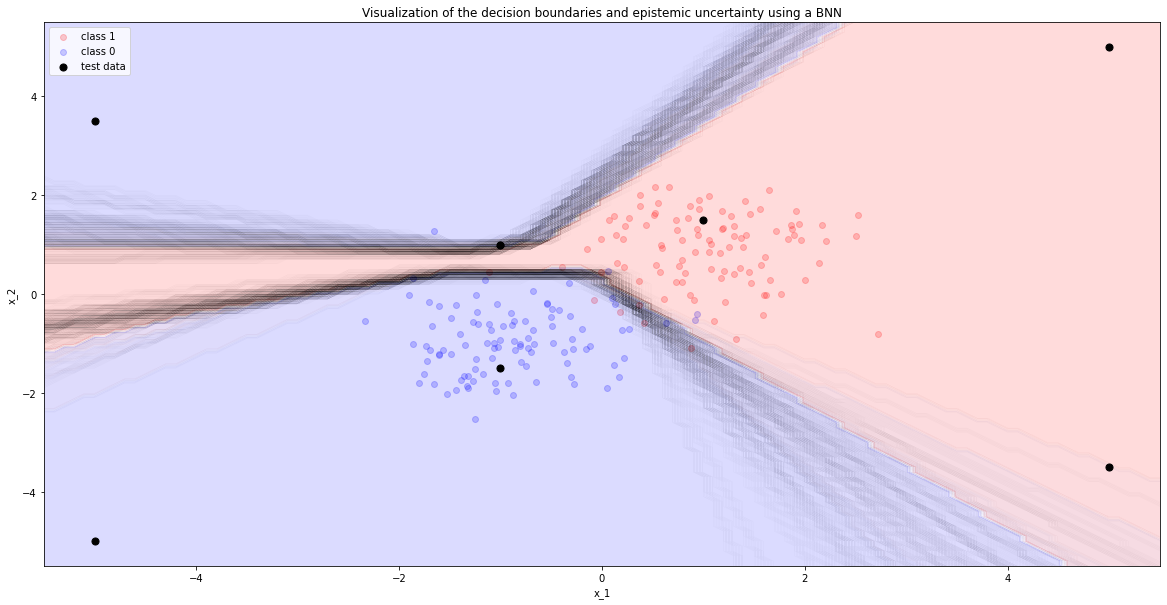

In [41]:
# create the models for the function plot_decision_boundary. We will select 100 posterior weights from the last 1000 
samples = samples[-100:]
models = []
for sample in samples:
    model = Bayesian_logistic_regression(sample, nn.forward)
    models.append(model)
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y, models, ax, test_points=test_points)
ax.set_title('Visualization of the decision boundaries and epistemic uncertainty using a BNN')
plt.show(fig)

Once again, the decision boundaries are very helpful in order for us to spot two different behaviours: 
- The *epistemic* uncertainty of our posterior for **in-sample** data lying at the boundary of classes will be quite high
- The *epistemic* uncertainty **OOD** for points lying very far from the classes and the decision boundaries will be very low. 

Therefore, the classification boundaries are an indicator that our Logistic Regression BNN will not be able to discriminate OOD test points.

**Exercise 2: (Epistemic Uncertainty from HMC)** Since the posterior $p(\mathbf{W} | \mathcal{D}))$ is a distribution over multiple models (i.e. decision boundaries) and each model outputs a classification probability for each test data point, the posterior $p(\mathbf{W} | \mathcal{D}))$ defines a distribution of classification probabilities for each test point. The variance of the distribution over classification probabilities is one way of quantifying the amount of ***epistemic uncertainty*** - uncertainty due to lack of observed training data - of the model at a particular test point.

Estimate the average epistemic uncertainty, under the posterior $p(\mathbf{W} | \mathcal{D}))$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Neural Network Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the posterior $p(\mathbf{W} | \mathcal{D}))$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Nerual Network Logistic Regression model is capable of distinguishing **all** possible OOD points.

In [49]:
variance_training = []
for training_point in x:
    probabilities_x=[]
    for model in models:
        proba_x = model.predict_proba(training_point.reshape(1, -1))
        probabilities_x.append(proba_x)
    variance_training.append(np.std(probabilities_x))
variance_testing = []
for testing_point in test_points:
    probabilities_t = []
    for model in models:
        testing_point = np.asarray([testing_point[0], testing_point[1]]) 
        proba_test=model.predict_proba(testing_point.reshape(1, -1))
        probabilities_t.append(proba_test)
    variance_testing.append(np.std(probabilities_t))

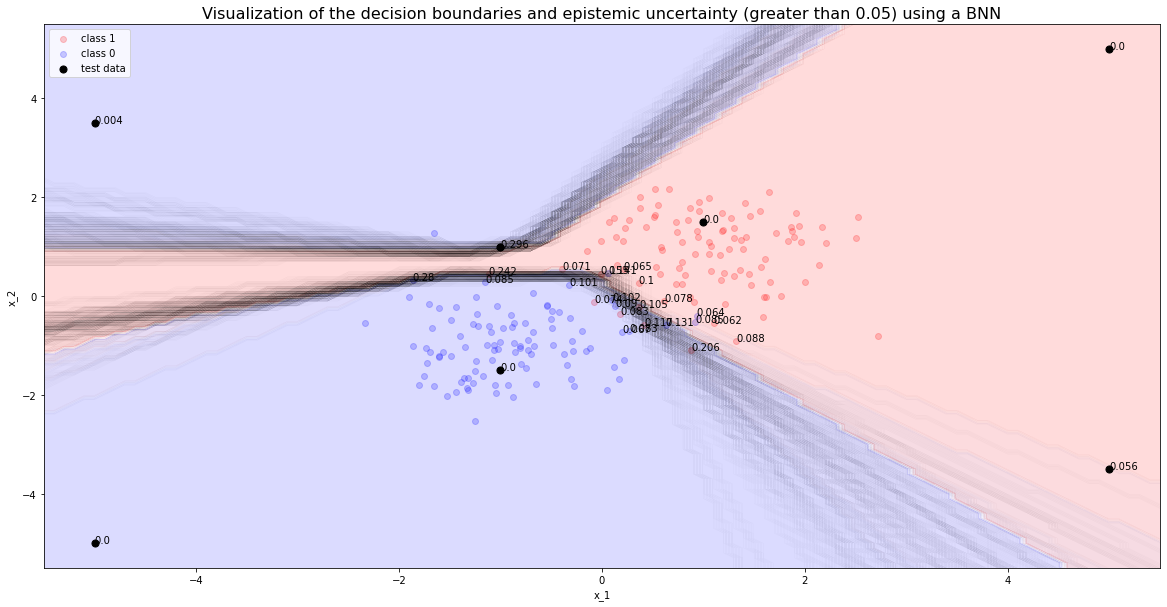

In [53]:
samples = samples[-100:]
models = []
for sample in samples:
    model = Bayesian_logistic_regression(sample, nn.forward)
    models.append(model)
fig, ax = plt.subplots(1, figsize=(20, 10))
plot_decision_boundary(x, y, models, ax, test_points=test_points, annotate_train=variance_training, annotate_test=variance_testing)
ax.set_title('Visualization of the decision boundaries and epistemic uncertainty (greater than 0.05) using a BNN', fontsize=16)
plt.show(fig)

The epistemic uncertainty as we defined it computes the variance of the prediction accross all of the posterior models of the BNN. Therefore, the epistemic uncertainty will be high when we have **diversity** on our posterior. From our previous visualization, we can therefore confidently say that we will have high uncertainty at the boundary. However, for OOD points lying far from the boundary, all of the BNN agreed due to the geometry of the boundary: there is no OOD uncertainty for points lying far from the boundarie.

**Exercise 3: (Bayesian Neural Network Logistic Regression with BBVI)** 
Use your implementation of BBVI with the reparametrization trick to approximate the posterior of the following Bayesian Neural Network Logistic Regression model for our toy dataset:

\begin{align}
\mathbf{W} &\sim \mathcal{N}(\mathbf{0}, 10\cdot \mathbf{I}_{D\times D})\\
Y^{(n)} &\sim Ber(\text{sigm}(f_\mathbf{W}( X^{(n)})))
\end{align}

where $\mathbf{X}$, $X^{(n)}$ are real-vector valued random variables, $f_\mathbf{W}$ is a neural network with weights $\mathbf{W}$, and where the data consists of the observations $(x^{(n)}, y^{(n)})$ in our toy dataset $\mathcal{D}$. Choose a neural network with 1 hidden layer and 5 hidden nodes.

Visualize the decision boundaries corresponding to the variational posterior samples. What do the distribution of decision boundaries tell you about the model's predictive uncertainties for each of the test points (particularly the OOD points)?

In HW#8, you've see that for regression, the posterior predictives of the same Bayesian Neural Network model can be quite different depending on whether or not inference was performed with HMC or BBVI. Compare the decision boundaries produced by BBVI with those by HMC, are these boundaries qualitatively different? Is this comparison expected or unexpected given your experience with these two inference methods from HW#8?

In [54]:
def black_box_variational_inference(logprob, D, num_samples):

    def unpack_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(params, t):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_params(params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, t))
        return -lower_bound  # modified for Gradient Ascent

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_params

In [65]:
def variational_inference(Sigma_W, y_train, x_train, S, max_iteration, step_size, verbose):
    '''implements wrapper for variational inference via bbb for bayesian regression'''
    D = Sigma_W.shape[0]
    Sigma_W_inv = np.linalg.inv(Sigma_W)
    Sigma_W_det = np.linalg.det(Sigma_W)
    variational_dim = D
    
    def sigmoid(x):
        return 1/(1 + np.exp(-x))

    def log_prior(w):
        D = len(w)
        logprior = -0.5 * (np.log(Sigma_det) + D * np.log(2 * np.pi))
        logprior += -0.5 * np.dot(np.dot(w, Sigma_inv), w.T)
        return logprior

    def log_likelihood(w):
        theta = nn.forward(w, x.T)
        theta = np.clip(theta, 1e-15, 1-1e-15)
        loglkhd = y * np.log(theta) +  ( 1 - y ) * np.log( 1 - theta )
        return np.sum(loglkhd)

    def log_target(w):
        return log_prior(w) + log_likelihood(w)

    #define the log joint density
    log_density = lambda w, t: log_likelihood(w) + log_prior(w)

    #build variational objective.
    objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=S)

    def callback(params, t, g):
        if verbose:
            if  t % 100 == 0:
                print("Iteration {} lower bound {}; gradient mag: {}".format(t, -objective(params, t), np.linalg.norm(gradient(params, t))))

    print("Optimizing variational parameters...")
    #initialize variational parameters
    init_mean = nn.weights.flatten()
    init_log_std = -100 * np.ones(D)
    init_var_params = np.concatenate([init_mean, init_log_std])

    #perform gradient descent using adam (a type of gradient-based optimizer)
    variational_params = adam(gradient, init_var_params, step_size=step_size, num_iters=max_iteration, callback=callback)

    return variational_params 

In [66]:
sigma_diagonal = 10
Sigma = sigma_diagonal*np.eye(nn.D)
posterior_vi = variational_inference(Sigma, y, x, S=10, max_iteration=50000, step_size=1e-3, verbose=True)

Optimizing variational parameters...
Iteration 0 lower bound -2275.525461292234; gradient mag: 56.828759760847674
Iteration 100 lower bound -2273.24433005239; gradient mag: 67.37645954821491
Iteration 200 lower bound -2270.8785646849296; gradient mag: 63.575557404609334
Iteration 300 lower bound -2268.504496236446; gradient mag: 55.799844147440105
Iteration 400 lower bound -2266.1301889349133; gradient mag: 60.14927407979335
Iteration 500 lower bound -2263.7698032797084; gradient mag: 56.971567533737094
Iteration 600 lower bound -2261.3902703515937; gradient mag: 56.16808314863107
Iteration 700 lower bound -2259.008263955376; gradient mag: 55.90648698768925
Iteration 800 lower bound -2256.6181428217574; gradient mag: 56.07513206017533
Iteration 900 lower bound -2254.2370238941376; gradient mag: 57.83797783478248
Iteration 1000 lower bound -2251.8364101289912; gradient mag: 53.32128317801581
Iteration 1100 lower bound -2249.450920170917; gradient mag: 54.257550038276314
Iteration 1200 l

Iteration 10300 lower bound -2043.8466629208815; gradient mag: 27.029430460530254
Iteration 10400 lower bound -2041.7388780157582; gradient mag: 23.210083341466405
Iteration 10500 lower bound -2039.639402667594; gradient mag: 29.56070929139153
Iteration 10600 lower bound -2037.5293522896122; gradient mag: 23.07207171230581
Iteration 10700 lower bound -2035.4256762030532; gradient mag: 23.705567710571408
Iteration 10800 lower bound -2033.3180521615852; gradient mag: 26.517806472616098
Iteration 10900 lower bound -2031.218900540811; gradient mag: 22.931378743597886
Iteration 11000 lower bound -2029.1158267001442; gradient mag: 19.1313215544302
Iteration 11100 lower bound -2027.0080735366391; gradient mag: 18.936005003426974
Iteration 11200 lower bound -2024.9082004041097; gradient mag: 28.866728917976708
Iteration 11300 lower bound -2022.806187073679; gradient mag: 23.428472845715167
Iteration 11400 lower bound -2020.7043921781108; gradient mag: 18.754851885015466
Iteration 11500 lower b

Iteration 20400 lower bound -1831.599742396961; gradient mag: 20.08289240555019
Iteration 20500 lower bound -1829.491343844504; gradient mag: 21.275813470318333
Iteration 20600 lower bound -1827.39977840502; gradient mag: 21.29223485288167
Iteration 20700 lower bound -1825.2917030373985; gradient mag: 18.438534584616963
Iteration 20800 lower bound -1823.1885756368424; gradient mag: 17.7908198841124
Iteration 20900 lower bound -1821.0908643355315; gradient mag: 17.71550003736597
Iteration 21000 lower bound -1818.9870665118233; gradient mag: 21.286927427456423
Iteration 21100 lower bound -1816.886093451827; gradient mag: 16.266974899003323
Iteration 21200 lower bound -1814.7883817927823; gradient mag: 27.92992946907091
Iteration 21300 lower bound -1812.6861825845026; gradient mag: 17.69783024659638
Iteration 21400 lower bound -1810.5885625381884; gradient mag: 27.243786458985767
Iteration 21500 lower bound -1808.4928186234354; gradient mag: 27.085258500981755
Iteration 21600 lower bound 

Iteration 30500 lower bound -1619.4629834538184; gradient mag: 26.342432102119695
Iteration 30600 lower bound -1617.3596296096787; gradient mag: 17.54367053474248
Iteration 30700 lower bound -1615.256065548352; gradient mag: 23.879639477528887
Iteration 30800 lower bound -1613.1551679434594; gradient mag: 26.638342864143937
Iteration 30900 lower bound -1611.0556458839558; gradient mag: 21.11451206797245
Iteration 31000 lower bound -1608.9575452843442; gradient mag: 17.286087787968775
Iteration 31100 lower bound -1606.8562603449382; gradient mag: 20.65486860168386
Iteration 31200 lower bound -1604.7595740008933; gradient mag: 24.247241458511397
Iteration 31300 lower bound -1602.6543801575665; gradient mag: 20.61263396325827
Iteration 31400 lower bound -1600.5555563940056; gradient mag: 24.261090111257825
Iteration 31500 lower bound -1598.463102896609; gradient mag: 24.48632993180453
Iteration 31600 lower bound -1596.3549897851449; gradient mag: 17.859089973516166
Iteration 31700 lower b

Iteration 40600 lower bound -1407.3412552823706; gradient mag: 23.595655654211495
Iteration 40700 lower bound -1405.2424787006955; gradient mag: 20.779389308070222
Iteration 40800 lower bound -1403.1459417114672; gradient mag: 20.2605138662453
Iteration 40900 lower bound -1401.0451060237851; gradient mag: 19.590226652486397
Iteration 41000 lower bound -1398.9392859471175; gradient mag: 17.071267087946154
Iteration 41100 lower bound -1396.8441797344701; gradient mag: 17.7750838177522
Iteration 41200 lower bound -1394.7448194414976; gradient mag: 17.290677426251147
Iteration 41300 lower bound -1392.6442935083883; gradient mag: 23.56249375869851
Iteration 41400 lower bound -1390.541327371945; gradient mag: 17.845574568014452
Iteration 41500 lower bound -1388.445187803124; gradient mag: 17.03221947276317
Iteration 41600 lower bound -1386.3435546503813; gradient mag: 20.262059156000536
Iteration 41700 lower bound -1384.245283533246; gradient mag: 23.96382881496636
Iteration 41800 lower boun

In [67]:
mean, cov = posterior_vi[:D], np.exp(posterior_vi[D:])

In [68]:
cov

array([1.92874888e-22, 1.92874888e-22, 1.92874888e-22, 1.92874888e-22,
       1.92874888e-22, 1.92874888e-22, 1.92874888e-22, 1.92874888e-22,
       1.92874888e-22, 1.92874888e-22, 1.92874888e-22, 1.92874888e-22,
       1.92874888e-22, 1.92874888e-22, 1.92874888e-22, 1.92874888e-22,
       1.92874888e-22, 1.92874888e-22, 1.92874888e-22, 1.92874888e-22,
       1.92874888e-22])

In [19]:
samples= np.random.multivariate_normal(mean = mean, cov = cov[0]*np.eye(D), size = 100)

**Exercise 4: (Epistemic Uncertainty from BBVI)** 

Estimate the average epistemic uncertainty, under the variational posterior $q(\mathbf{W})$, of the data points in the toy data set, then estimate the epistemic uncertainty of each test data point. Interpret these uncertainties, in particular, explain to what extend can the epistemic uncertainties of this Bayesian Neural Network Logistic Regression model be used to distinguish in-distribution points from OOD points. 

Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries in the variational posterior $q(\mathbf{W})$. Using this geometric relationship, explain whether or not the epistemic uncertainties of our Bayesian Nerual Network Logistic Regression model with BBVI is capable of distinguishing **all** possible OOD points.

**Exercise 5: (Bayesian Neural Network Logistic Regression with Larger Architecture)** 

Vary the depth and width of your Bayesian Neural Network Logistic Regression model. Try depths `depth=[1, 2, 5]` and widths `width=[5, 10, 50, 100]`. Perform variational inference in each case to obtain an approximate posterior.

Visualize the decision boundaries corresponding to the variational posterior samples for each combination of depth and width (you may want to arrange your plots in a grid). What is the effect of depth and width of the neural network on the boundaries in the variational posteriors?

If we want to be able to accurately detect OOD points using epistemic uncertainty, as defined above, what architecture choices should we make for our Bayesian Neural Network Logistic Regression model?

**Exercise 6: (Bayesian Neural Network Logistic Regression with Different Priors)** 

Fixing a sufficiently expressive network architecture (say depth 5 and width 50), vary the variance of your Bayesian Neural Network Logistic Regression prior. Try variance of `var=[0.1, 1, 5, 10, 20]`.

Visualize the decision boundaries corresponding to the variational posterior samples for each prior variance (you may want to arrange your plots in a grid). What is the effect of prior variance on the boundaries in the variational posteriors?

If we want to be able to accurately detect OOD points using epistemic uncertainty, as defined above, what model choices should we make for our Bayesian Neural Network Logistic Regression model?

**Exercise 7: (Bootstraping Neural Network Logistic Regression)** 

Perform bootstrap Neural Network Logistic Regression on the toy dataset. Obtain 100 bootstrap Neural Network Logistic Regression models using various different architectures. Try depths `depth=[1, 2, 5]` and widths `width=[5, 10, 50, 100]`. 

Visualize the decision boundaries corresponding to the samples in the bootstrap ensemble for each combination of depth and width (you may with to arrange your plots in a grid). Are the epistemic uncertainties of each ensemble able to distinguish in-distribution test points from OOD ones? Relate the amount of epistemic uncertainty at a particular data point to the decision boundaries of the models in each ensemble. Using this geometric relationship, explain whether or not the epistemic uncertainties of our bootstrap ensemble is capable of distinguishing **all** possible OOD points.

If we want to be able to accurately detect OOD points using epistemic uncertainty, as defined above, what architecture choices should we make for our bootstrap Neural Network Logistic Regression ensemble?

**Exercise 8: (Comparing Bayesian and Frequentist Approaches to OOD Identification)** Based on your empirical results from above, discuss the pros and cons of using bootstrap ensemble, Bayesian model with HMC and Bayesian model with BBVI in the task of OOD identification. 